In [1]:
import numpy as np
import numpy.random as npr
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from easydict import EasyDict as edict
from collections import defaultdict as ddict
import torch
import time
from tqdm.autonotebook import tqdm
from scipy import signal
import time
import pickle

%matplotlib inline

In [2]:
from cUtils import *
from Rfuns import bw_nrd0_R
from tmpUtils import *

In [3]:
class TVDNextOpt():
    """
        The class to implement the full procedure of TVDNext method
    """
    def __init__(self, rawDat, fs, T, Rn, hs, **paras):
        """
         Input: 
             rawDat: The raw dataset, tensor of d x dT+1
             fs: The sampling freq of the raw dataset
             T: Time course of the data
             Rn: The nominal rank of A mat, Rn << d to reduce the computational burden 
             hs: the bandwidths for the kernel regression whe estimating A matrix
             paras:
                 is_ConGrads: Whether use conjugate gradient descend or not in the inner loop
                 penaltys: The penalty in the inner loop
               For Preprocess:
                 lamb: parameter for smoothing, if None, not smooth
                 is_detrend: Whether detrend the raw data or not
                 bandsCuts: the cirtical freqs to use
                 Nord: The order of the filter
                 q: The decimate rate
                 
               For A matrix:
                 downrates: The downrate factors for freq and time, determine how many A(s_i, t_i) matrix to be summed
                 
               For one-step Opt:
                 betas: list of two tuning parameter for iteration
                 alps: list of two tuning parameter for iteration
                 rhos: list of two vectors of length (dF-1)2R and (dT-1)2R, real data
                 lams: list of two parameters for SCAD, for mu and nu
                 As: list of two parameters for SCAD for mu and nu, > 1+1/beta
                 iterNums:  integer or list of two integers, number of iterations for one-step-opt
                 iterCs: decimal or list of two decimate, stopping rule for one-step-opt
               
               For the outer optimization procedure:
                 paraMuInit: The initial value of mu parameters, along the freq axis
                 paraNuInit: The initial value of nu parameters, along the time axis
                 maxIter: Integer, the maximal times of iteration for the outer loop
                 outIterC:  decimal, stopping rule for the outer loop
        """
        parasDefVs = { "lamb": None, "penaltys": ["SCAD", "SCAD"], "is_ConGrads":[False, True],
                      "is_detrend": True, "bandsCuts": [[2, 3.5], [4, 7], [8, 12], [13, 30], [30, 80]], 
                      "Nord": None, "q": 10, 
                      "downrates": [1, 10],  "betas":[1, 1], "alps": [0.9, 0.9],  "rhos": None,  "lams": None, 
                      "As": [2.7, 2.7],  "iterNums": [5, 1], "iterCs": None, "paraMuInit": None,
                      "paraNuInit": None, "maxIter": 100, "outIterC": None
                    }
        self.paras = edict(parasDefVs)
        for key in paras.keys():
            self.paras[key] = paras[key]
            
        if self.paras.iterCs is None:
            self.paras.iterCs = [None, None]
        
            
        self.rawDat = rawDat
        self.fs, self.T = fs, T
        self.Rn = Rn
        self.hs = hs 
        
        # Some none definitions
        self.X = self.Y = self.pUinv = None
        self.dF = self.dT = self.D = self.nD = None
        self.lastThetaMu = self.lastTheteNu = None # Vector of 2R(dF-1)/2R(dT-1)
        self.paraMu = self.paraNu = None # matrix of 2R x dF/dT
        self.kpidx = None
        self.R = self.R2 = None
        self.U = None
        
    def _PreProcess(self):
        """
        add smooth ?
        
        To preprocess the raw dataset, including 
            1. Detrend, 
            2. Filter under bands
            3. Decimate
        """
        
        dat = signal.detrend(self.rawDat)
        # smooth after detrend
        if self.paras.lamb is not None:
            times = np.linspace(0, self.T, dat.shape[1])
            dat = GetBsplineEst(dat, times, lamb=self.paras.lamb)
        
        cDat = mat2Tensor(dat, fs=self.fs, q=self.paras.q)
        # if self.paras.lamb is not None:
        #     times = np.linspace(0, self.T, cDat.shape[2])
        #     cDat = GetBsplineEst(cDat, times, lamb=self.paras.lamb)
        # Avoid stride problem when convert numpy to tensor
        self.X = torch.tensor(cDat.copy()[:, :, :-1])
        self.Y = torch.tensor(cDat.copy()[:, :, 1:])
        
    def _estAmat(self):
        _, self.dF, self.dT = self.Y.shape
        times = np.linspace(0, self.T, self.dT)
        freqs = np.array([np.mean(bandCut) for bandCut in self.paras.bandsCuts])
        if self.hs is None:
            self.hs = [bw_nrd0_R(freqs), bw_nrd0_R(times)]
        
        self.Amat = GetAmatTorch(self.Y, self.X, times, freqs, self.paras.downrates, self.hs)
        
        res = np.linalg.eig(self.Amat)
        absEigVs = np.abs(res[0])
        # Sort the eigvs and vectors such that the vals is in order
        sortIdx = np.argsort(absEigVs)[::-1]
        lams = res[0][sortIdx]
        U = res[1][:, sortIdx]
        self.U = U
        
        eigF = np.concatenate([[np.inf], lams])
        # To remove conjugate eigvector
        self.kpidx = np.where(np.diff(np.abs(eigF))[:self.Rn] != 0)[0] 
        # Only for test
        # self.kpidx = np.arange(self.Rn) 
        self.R = len(self.kpidx)
        self.R2 = 2 * self.R
        
        Uinv = np.linalg.inv(U)
        pUinv = Uinv[self.kpidx, :]
        self.pUinv = torch.tensor(pUinv)
        
    def __call__(self, showSubProg=False, **runParas):
        for key in runParas:
            self.paras[key] = runParas[key]
            
        if self.X is None:
            self._PreProcess()
        if self.pUinv is None:
            self._estAmat()
        
        _, self.dF, self.dT = self.X.shape
        
        self.D = self.dF
        self.nD = int(self.dF*self.dT/self.D)
        if self.paras.paraMuInit is None:
            self.paras.paraMuInit = torch.rand(self.R2, self.dF)
        if self.paras.paraNuInit is None:
            self.paras.paraNuInit = torch.rand(self.R2, self.dT)
        if self.paras.rhos is None:
            rho1 = torch.ones(self.R2*(self.dF-1))
            rho2 = torch.ones(self.R2*(self.dT-1))
            self.paras.rhos = [rho1, rho2]
            
        
        
        chDiffBoth = torch.tensor(1e10) # Stopping rule
        
        lastMuTheta = DiffMatOpt(colStackFn(self.paras.paraMuInit), self.R2)
        fixedNuMat = self.paras.paraNuInit
        
        stopLastMuMat = self.paras.paraMuInit
        stopLastNuMat = self.paras.paraNuInit
        
        pbar = tqdm(range(self.paras.maxIter))
        for i in pbar:
            if i == 0:
                pbar.set_description(f"Outer Loop: The chdiff is {chDiffBoth.item():.3e}.")
            else:
                pbar.set_description(f"Outer Loop:"
                                     f"{chDiffMu.item():.3e}, "
                                     f"{chDiffNu.item():.3e}, "
                                     f"{chDiffBoth.item():.3e}.")
            optMu = OneStepOpt(X=self.X, Y=self.Y, pUinv=self.pUinv, fixedParas=fixedNuMat, lastTheta=lastMuTheta, 
                               penalty=self.paras.penaltys[0], is_ConGrad=self.paras.is_ConGrads[0],
                               alp=self.paras.alps[0], beta=self.paras.betas[0], lam=self.paras.lams[0], 
                               a=self.paras.As[0], iterNum=self.paras.iterNums[0], rho=self.paras.rhos[0], iterC=self.paras.iterCs[0])
            optMu(showSubProg)
            
            fixedMuMat = optMu.GamMatStd
            if i == 0:
                lastNuTheta = DiffMatOpt(colStackFn(fixedNuMat), self.R2)
            else:
                lastNuTheta = optNu.lastTheta
            
            optNu = OneStepOpt(X=self.X, Y=self.Y, pUinv=self.pUinv, fixedParas=fixedMuMat, lastTheta=lastNuTheta, 
                               penalty=self.paras.penaltys[1], is_ConGrad=self.paras.is_ConGrads[1],
                               alp=self.paras.alps[1], beta=self.paras.betas[1], lam=self.paras.lams[1], 
                               a=self.paras.As[1], iterNum=self.paras.iterNums[1], rho=self.paras.rhos[1], iterC=self.paras.iterCs[1])
            optNu(showSubProg)
            
            fixedNuMat = optNu.GamMat
            # lastMuTheta = DiffMatOpt(colStackFn(fixedMuMat), self.R2)
            lastMuTheta = optMu.lastThetaStd
            
            chDiffMu = torch.norm(stopLastMuMat-fixedMuMat)/torch.norm(stopLastMuMat)
            chDiffNu = torch.norm(stopLastNuMat-fixedNuMat)/torch.norm(stopLastNuMat)
            chDiffBoth = torch.max(chDiffMu,chDiffNu)
            
            stopLastMuMat = fixedMuMat
            stopLastNuMat = fixedNuMat
            # if show_prog:
            #     if (i+1) % thin == 1:
            #         print(f"Current iteration is {i+1}/{self.paras.maxIter}, the change of diff is {chDiffBoth}")
            if chDiffBoth <= self.paras.outIterC:
                break
            
        self.paraMu = stopLastMuMat
        self.paraNu = stopLastNuMat
        self.lastOptMu = optMu
        self.lastOptNu = optNu

In [4]:
if torch.cuda.is_available():
    torch.cuda.set_device(2)

In [5]:
resDir = Path("../results")
dataDir = Path("../data/MEG-eye-unfiltering-0203")

In [6]:
list(dataDir.glob("*02*min.mat"))

[PosixPath('../data/MEG-eye-unfiltering-0203/lcmv_result_R2868E_02-st_wo_filtering_min.mat')]

In [7]:
datFil = list(dataDir.glob("*02*min.mat"))[0]
print(datFil)
gtF = list(dataDir.glob("*02_st.txt"))[0]

../data/MEG-eye-unfiltering-0203/lcmv_result_R2868E_02-st_wo_filtering_min.mat


Time course is $60$s, so freq is $1200$ Hz.

In [8]:
rawDat = loadmat(datFil)
dat = rawDat["DK_timecourse"]
d, Nall = dat.shape

In [9]:
fs = 1200
Rn = 4
T = 6

lams = [2e2, 1e3]
#lams = [1e2, 1e3]
downrates = [1, 4]
q = 50
iterNums = [1000, 100]
iterCs = [1e-6, 1e-6]
As = [2.7, 2.7]
alps = [0.9, 0.9]
outIterC = 1e-5
betas = [100, 100]
penaltys = ["GroupLasso", "GroupLasso"]

In [10]:
# GT under current q
gtSt02 = time2pts(txt2Time(gtF), timeLims.st02, Up=int(Nall/q))

In [11]:
fOpt = TVDNextOpt(rawDat=dat, fs=fs, T=T, Rn=Rn, hs=None, lamb=None, lams=lams, downrates=downrates, q=q, is_ConGrads=[False, False],
                  iterNums=iterNums, iterCs=iterCs, As=As, alps=alps, penaltys=penaltys,
                  outIterC=outIterC, maxIter=1000, betas=betas, 
                  paraMuInit=None,paraNuInit=None)

In [12]:
fOpt(True, maxIter=50)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [13]:
eMus = fOpt.lastOptMu.GamMatStd.cpu().numpy()
eMusThetas = fOpt.lastOptMu.ThetaMatStd.cpu().numpy()
eDiffMus = np.diff(eMus)

eNus = fOpt.lastOptNu.GamMat.cpu().numpy()
eNusThetas = fOpt.lastOptNu.ThetaMat.cpu().numpy()
eDiffNus = np.diff(eNus)

([], [])

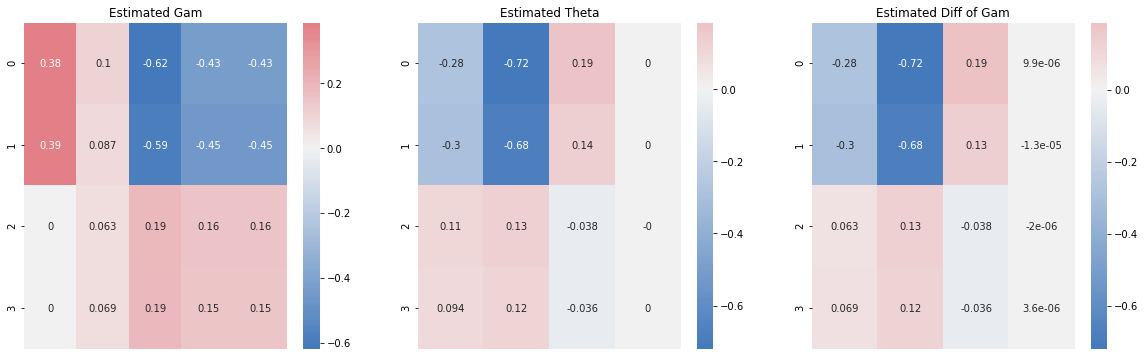

In [14]:
myCmap = sns.diverging_palette(250, 10, as_cmap=True)
plt.figure(figsize=[20, 6])

is_annot = True

plt.subplot(131)
plt.title("Estimated Gam")
sns.heatmap(eMus, cmap=myCmap,  annot=is_annot, center=0)
#sns.heatmap(np.abs(eMus), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(132)
plt.title("Estimated Theta")
sns.heatmap(eMusThetas, cmap=myCmap,  annot=is_annot, center=0)
# sns.heatmap(np.abs(eMusThetas), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(133)
plt.title("Estimated Diff of Gam")
sns.heatmap(eDiffMus, cmap=myCmap,  annot=is_annot, center=0)
# sns.heatmap(np.abs(eDiffMus), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

([], [])

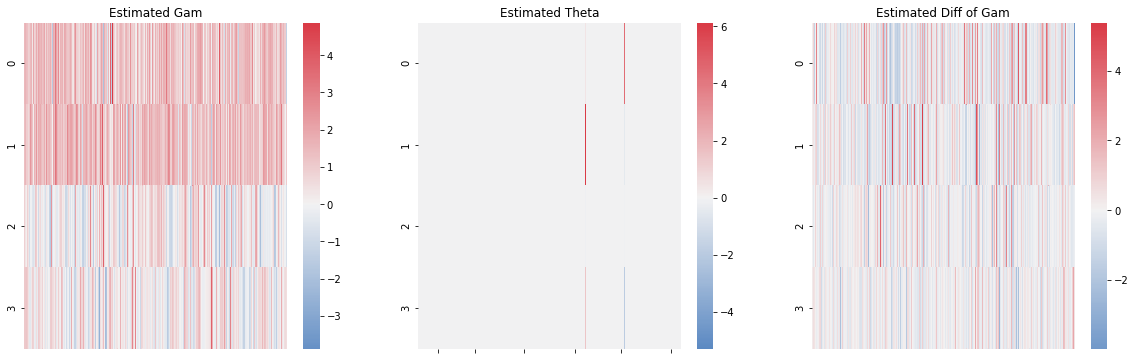

In [15]:
plt.figure(figsize=[20, 6])

is_annot = False
plt.subplot(131)
plt.title("Estimated Gam")
sns.heatmap(eNus, cmap=myCmap,  annot=is_annot, center=0)
# sns.heatmap(np.abs(eNus), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(132)
plt.title("Estimated Theta")
sns.heatmap(eNusThetas, cmap=myCmap,  annot=is_annot, center=0)
#sns.heatmap(np.abs(eNusThetas), cmap="YlOrRd",  annot=is_annot)
_ = plt.xticks(gtSt02.cpts)

plt.subplot(133)
plt.title("Estimated Diff of Gam")
sns.heatmap(eDiffNus, cmap=myCmap,  annot=is_annot, center=0)
# sns.heatmap(np.abs(eDiffNus), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])